# Loading the dataset:

In [1]:
import pandas as pd

dataset = pd.read_csv('insurance.csv')

print(f"Shape: {dataset.shape}")

dataset.head()

Shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Preprocessing the data:

In [2]:
# Preprocessing the data:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

copied_dataset = dataset.copy()

# Choosing the numeric and non-numeric values:
features_num = [col for col in copied_dataset.select_dtypes(include=['int', 'float']).columns]
features_cat = [col for col in copied_dataset.select_dtypes(exclude=['int', 'float']).columns]

print(f"Numeric features: {features_num}")
print(f"Non-numeric features: {features_cat}")

preprocessor = make_column_transformer (
    (StandardScaler(), features_num),
    (OrdinalEncoder(), features_cat),
    remainder='passthrough'
)

columns = features_num + features_cat
transformed_dataset = preprocessor.fit_transform(copied_dataset)
transformed_dataset = pd.DataFrame(data=transformed_dataset, columns=columns)

transformed_dataset.head()

Numeric features: ['age', 'bmi', 'children', 'charges']
Non-numeric features: ['sex', 'smoker', 'region']


,age,bmi,children,charges,sex,smoker,region
0,-1.438764,-0.453320,-0.908614,0.298584,0.0,1.0,3.0
1,-1.509965,0.509621,-0.078767,-0.953689,1.0,0.0,2.0
2,-0.797954,0.383307,1.580926,-0.728675,1.0,0.0,2.0
3,-0.441948,-1.305531,-0.908614,0.719843,1.0,0.0,1.0
4,-0.513149,-0.292556,-0.908614,-0.776802,1.0,0.0,1.0


# Observing the data:

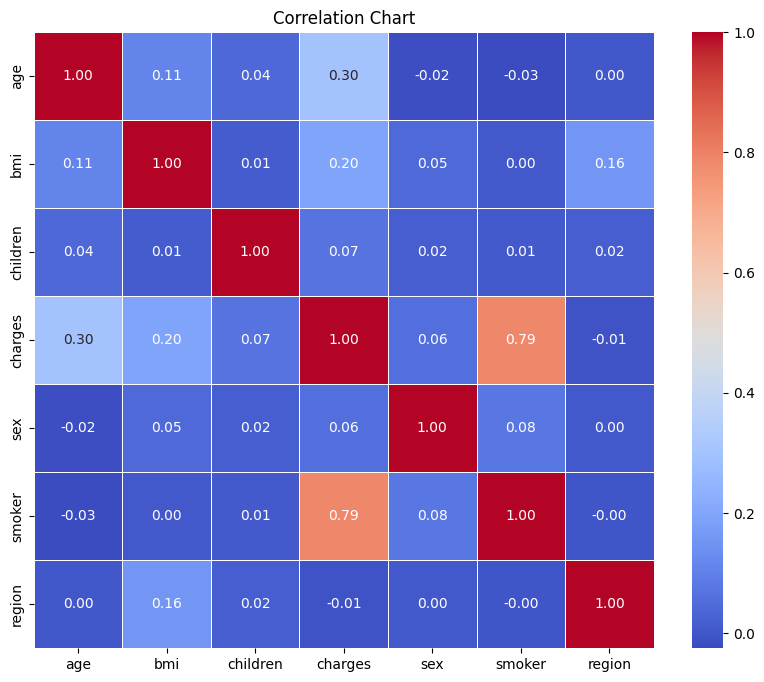

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix:
corr_matrix = transformed_dataset.corr()

# Create a correlation chart:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Chart")
plt.show()

From observing the data we can see that charges are most highly correlated to (by magnitude):
1. Whether the person smokes
2. How old is the person
3. The person's BMI

All other factors are not so much related so they will be removed

In [4]:
# Removing unrelated columns:
filtered_dataset = transformed_dataset
# filtered_dataset = transformed_dataset[['smoker', 'age', 'bmi', 'charges']]

# # Compute new correlation matrix:
# corr_matrix = filtered_dataset.corr()

# # Create a new correlation chart:
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# plt.title("Correlation Chart")
# plt.show()

# Splitting to train and validation data:

In [5]:
from sklearn.model_selection import train_test_split

# Separating X and y:
y = filtered_dataset['charges']
X = filtered_dataset.drop('charges', axis=1)

# Splitting the data:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

print(f"X train: {X_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y train: {y_train.shape}")
print(f"y test: {y_test.shape}")

X train: (936, 6)
X test: (402, 6)
y train: (936,)
y test: (402,)


# Creating the model:

In [18]:
from tensorflow import keras

# Creating the model:
input_shape = X_train.shape[1],
model = keras.Sequential([
    keras.layers.Dense(32, input_shape=input_shape, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='linear'),
    keras.layers.BatchNormalization(),
])

# Compiling the model:
model.compile(
    optimizer='adam',
    loss='mean_absolute_error',
)

In [19]:
# Training the model:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=100,
    verbose=0
)


Minimum training Loss: 0.1959
Minimum Validation Loss: 0.1493


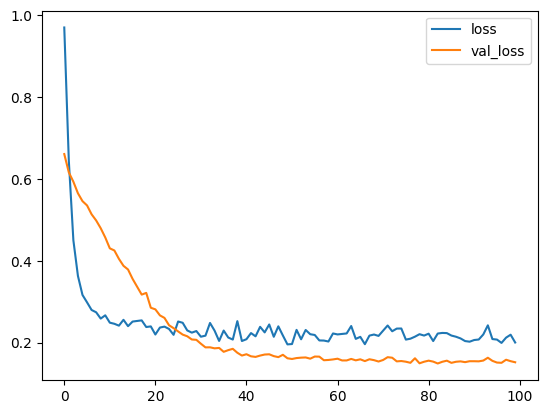

In [20]:
# Displaying the history:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum training Loss: {:0.4f}".format(history_df['loss'].min()));
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# Testing the accuracy of the model:
Using the r2 squared value to determine how accurate is the model:

In [21]:
from sklearn.metrics import r2_score

# Making predictions using the model:
y_pred = model.predict(X_test)

decimals = 3
r2 = round(r2_score(y_true=y_test, y_pred=y_pred), decimals)
print(f"R2 squared score: {r2}")

13/13 [==============================] - 0s 2ms/step
R2 squared score: 0.86


# Saving the model:

In [22]:
# Saving the model ONLY if its accuracy is larger than the most accurate saved model:
import os

MODELS_DIR = "saved_models"

models = os.listdir(MODELS_DIR)

# Finding the maximum accuracy:
max_acc = 0
for model_name in models:
    # Removing acc from the file's name:
    acc = model_name[model_name.find('acc') + 3:]
    # Getting the numerical value:
    acc = int(acc) * (10 ** -len(acc))
    # Getting the max value:
    max_acc = max(max_acc, acc)

print(f"Max accuracy: {max_acc}")
should_save = r2 > max_acc

Max accuracy: 0.859


In [23]:
if should_save:
    # Saving the model based on the accuracy:
    PATH = "saved_models/acc" + str(int(r2 * 10 ** decimals))

    print(f"Saved at: {PATH}")

    model.save(PATH)
else:
    print("Didn't save")

Saved at: saved_models/acc860
INFO:tensorflow:Assets written to: saved_models/acc860\assets
